In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model

In [2]:
df = pd.read_excel("SCUT-FBP5500_v2/All_Ratings.xlsx")
df.head()

,Rater,Filename,Rating,original Rating
0,1,CF1.jpg,3,NaN
1,1,CF10.jpg,3,NaN
2,1,CF100.jpg,1,NaN
3,1,CF101.jpg,2,NaN
4,1,CF102.jpg,3,NaN


In [3]:
df = df.drop(columns="original Rating", axis=1)
df.head()

,Rater,Filename,Rating
0,1,CF1.jpg,3
1,1,CF10.jpg,3
2,1,CF100.jpg,1
3,1,CF101.jpg,2
4,1,CF102.jpg,3


In [4]:
# df_y = df.groupby("Filename")["Rating"].apply(lambda x: x.mode().iloc[0]).reset_index()
df_y = df.groupby("Filename")["Rating"].mean().reset_index()
file_name = df_y[["Filename"]].to_numpy().flatten()
df_y = df_y["Rating"].to_numpy() / 5

In [5]:
df_y

array([0.46666667, 0.68666667, 0.58      , ..., 0.61      , 0.48      ,
       0.53333333])

In [6]:
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    """
    이미지를 불러와 전처리합니다.
    img_path: 이미지 경로
    target_size: CNN 입력으로 사용할 이미지의 크기
    """
    path = "SCUT-FBP5500_v2/Images/"
    img = image.load_img(path+img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # 모델에 입력하기 위해 차원을 확장
    return img_array / 255.0  # 이미지를 [0, 1] 범위로 정규화

def load_images(image_filenames, target_size=(224, 224)):
    images = [load_and_preprocess_image(img_path, target_size) for img_path in image_filenames]
    return np.vstack(images)  # 이미지 목록을 하나의 배열로 합치기

In [7]:
# 함수를 사용하여 이미지 데이터를 준비
df_x = load_images(file_name)

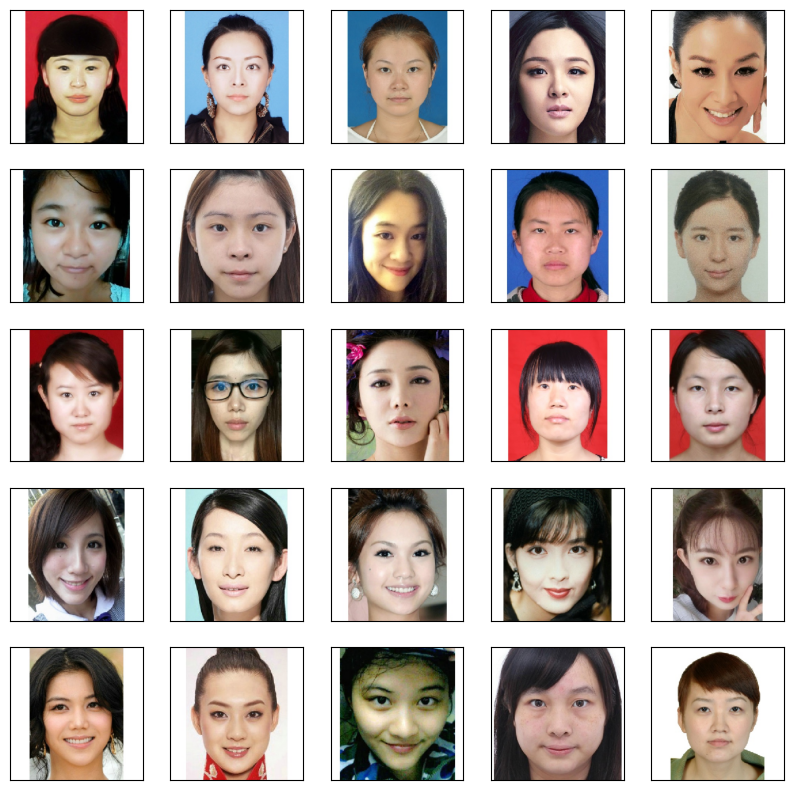

In [8]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(df_x[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
plt.show()

In [9]:
df_x.shape

(5500, 224, 224, 3)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=1234)
x_train, x_valid, y_train, y_valid  =train_test_split(x_train, y_train, test_size=0.25, random_state=1234)

In [11]:
print(x_train.shape, x_valid.shape, x_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(3300, 224, 224, 3) (1100, 224, 224, 3) (1100, 224, 224, 3)
(3300,) (1100,) (1100,)


In [12]:
base_model = ResNet50(weights='imagenet', include_top=False)
# for layer in base_model.layers:
#     layer.trainable = False

In [13]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dense(8, activation='relu')(x)
x = layers.Dense(4, activation='relu')(x)
predictions = layers.Dense(1, activation='linear')(x)  # 회귀 문제이므로 출력 뉴런은 1개, 활성화 함수는 linear
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

In [14]:
from tensorflow.keras import backend as K

def rmse_loss(y_true, y_pred):
    err = y_true - y_pred
    loss = tf.math.sqrt(tf.math.reduce_mean(tf.math.square(err)))
    return loss

 
def plcc_loss(y_true, y_pred):  
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym)))) + 1e-12
    r = r_num / r_den
    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return 1 - r

def plcc_metric(y_true, y_pred):  
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym)))) + 1e-12
    return r_num / r_den

In [15]:
model.compile(optimizer='adam', loss='mse', metrics=plcc_metric)
history = model.fit(x_train, y_train, batch_size=16, epochs=20, validation_data=(x_valid, y_valid))

Epoch 1/20
207/207 [==============================] - 28s 102ms/step - loss: 0.0218 - plcc_metric: 0.6683 - val_loss: 0.0199 - val_plcc_metric: 0.1136
Epoch 2/20
207/207 [==============================] - 20s 98ms/step - loss: 0.0084 - plcc_metric: 0.8290 - val_loss: 0.0216 - val_plcc_metric: 0.2147
Epoch 3/20
207/207 [==============================] - 20s 97ms/step - loss: 0.0073 - plcc_metric: 0.8711 - val_loss: 0.0197 - val_plcc_metric: 0.3567
Epoch 4/20
207/207 [==============================] - 20s 96ms/step - loss: 0.0054 - plcc_metric: 0.8910 - val_loss: 0.0090 - val_plcc_metric: 0.7394
Epoch 5/20
207/207 [==============================] - 20s 96ms/step - loss: 0.0046 - plcc_metric: 0.9158 - val_loss: 0.0100 - val_plcc_metric: 0.8082
Epoch 6/20
207/207 [==============================] - 20s 96ms/step - loss: 0.0052 - plcc_metric: 0.9270 - val_loss: 0.0057 - val_plcc_metric: 0.8642
Epoch 7/20
207/207 [==============================] - 20s 96ms/step - loss: 0.0041 - plcc_metric: 0

In [16]:
predict = model.predict(x_test)

35/35 [==============================] - 2s 38ms/step


In [17]:
y_pred = predict.flatten()*5
y_true = y_test * 5

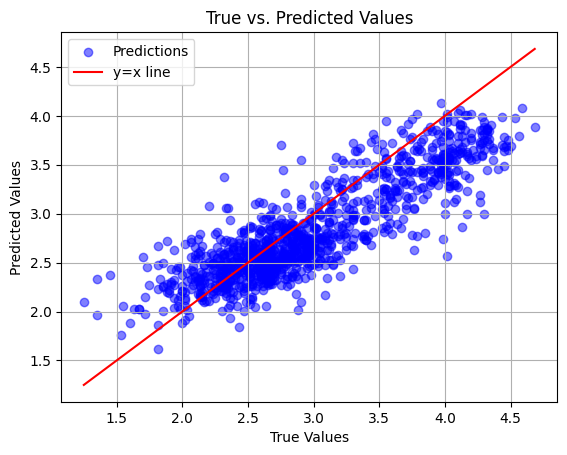

<Figure size 640x480 with 0 Axes>

In [18]:
plt.scatter(y_true, y_pred, color='blue', alpha=0.5, label='Predictions')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', label='y=x line')

plt.title('True vs. Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig("t3_mse.jpg")

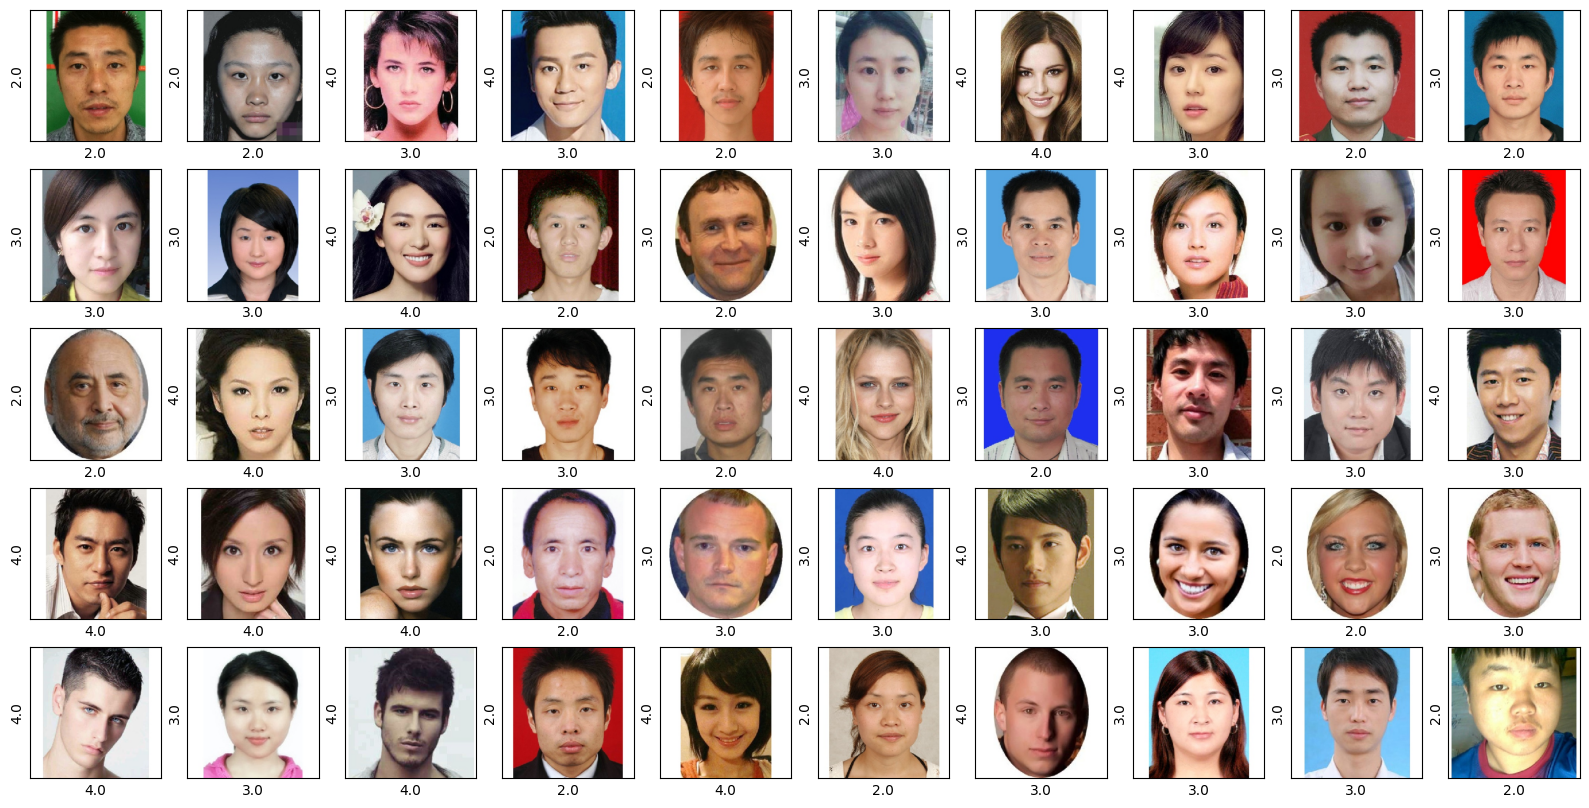

In [19]:
plt.figure(figsize=(20,10))
for i in range(50):
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i+30])
    plt.ylabel(y_true[i+30].round())
    plt.xlabel(y_pred[i+30].round())
plt.show()

In [20]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))
rmse_val = rmse(y_true, y_pred)
mae_val = mae(y_true, y_pred)

print(f"RMSE: {rmse_val:.4f}")
print(f"MAE: {mae_val:.4f}")

RMSE: 0.3788
MAE: 0.3003


In [21]:
def pearson_correlation(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0, 1]
correlation = pearson_correlation(y_true, y_pred)
print(f"Pearson Correlation Coefficient: {correlation:.4f}")

Pearson Correlation Coefficient: 0.8676


In [22]:
y_pred1 = y_pred.round()
y_true1 = y_true.round()

In [23]:
np.mean(y_pred1==y_true1)

0.6618181818181819

In [24]:
# model.save("restnet50_1.h5", save_format='h5')

In [27]:
from tensorflow import keras
model2 = keras.models.load_model("restnet50_1.h5", custom_objects={'plcc_metric': plcc_metric})

In [28]:
model2.compile(optimizer='adam', loss='mse')

In [29]:
predict = model2.predict(x_test)

35/35 [==============================] - 2s 40ms/step


In [30]:
y_pred = predict.flatten()*5
y_true = y_test * 5

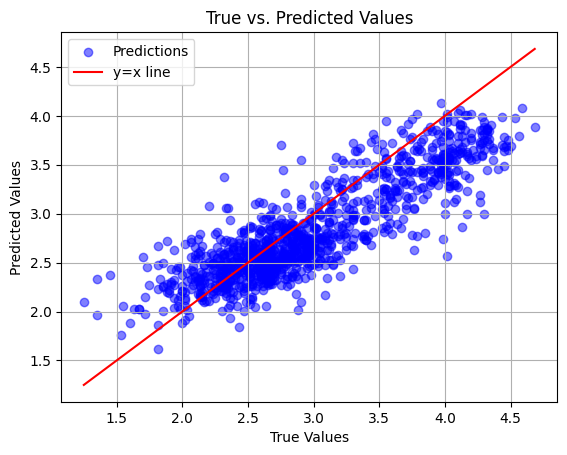

<Figure size 640x480 with 0 Axes>

In [31]:
plt.scatter(y_true, y_pred, color='blue', alpha=0.5, label='Predictions')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', label='y=x line')

plt.title('True vs. Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig("t3_mse.jpg")